# Sentiment Analysis of Restaurant Review


## Imports

In [111]:
import math
import numpy as np
import pandas as pd
import jieba
import torch
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [112]:
np.random.seed(1701)
torch.manual_seed(1701)
torch.cuda.manual_seed_all(1701)     

## Data processing

In [113]:
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))

def make_label(star):
    if star > 3:
        return 1
    else:
        return 0
    
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file) as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

In [114]:
class ReviewDataset(Dataset):
    def __init__(self, data):
        self.n_samples, self.n_features = data.shape
        # The first column is label, the rest are the features
        self.n_features -= 1 
        self.feature = torch.from_numpy(data[:, :-1].astype(np.float32)).cuda() # size [n_samples, n_features]
        self.label = torch.from_numpy(data[:, [-1]].astype(np.float32)).cuda() # size [n_samples, 1]        
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.feature[index], self.label[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

### Read data and add columns

In [115]:
%%time
data = pd.read_csv('data0.csv', nrows=8100, usecols=['star','comment'])
#data = pd.read_csv('data0.csv')    
data['sentiment'] = data.star.apply(make_label)
data['cut_comment'] = data.comment.apply(chinese_word_cut)

#X = data['cut_comment']
#y = data.sentiment

Wall time: 3.76 s


### Vectorization

In [116]:
%%time
stop_words_file = '哈工大停用词表.txt'
stopwords = get_custom_stopwords(stop_words_file)

vect = CountVectorizer(max_df = 1.0, 
                       min_df = 1, 
                       max_features = None,
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b', 
                       stop_words=frozenset(stopwords))

vect1 = TfidfVectorizer(#max_features = 5000,
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b', 
                       stop_words=frozenset(stopwords))

X = pd.DataFrame.sparse.from_spmatrix(vect.fit_transform(data['cut_comment']), columns=vect.get_feature_names())
#X = pd.DataFrame.sparse.from_spmatrix(vect1.fit_transform(data['cut_comment']), columns=vect1.get_feature_names())
Xy = X.assign(label=data.sentiment)
train, test = train_test_split(Xy.values, test_size=0.1)
train, test = ReviewDataset(train), ReviewDataset(test)

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exp', 'lex', '①①', '①②', '①③', '①④', '①⑤', '①⑥', '①⑦', '①⑧', '①⑨', '①ａ', '①ｂ', '①ｃ', '①ｄ', '①ｅ', '①ｆ', '①ｇ', '①ｈ', '①ｉ', '①ｏ', '②①', '②②', '②③', '②④', '②⑤', '②⑥', '②⑦', '②⑧', '②⑩', '②ａ', '②ｂ', '②ｄ', '②ｅ', '②ｆ', '②ｇ', '②ｈ', '②ｉ', '②ｊ', '③①', '③⑩', '③ａ', '③ｂ', '③ｃ', '③ｄ', '③ｅ', '③ｆ', '③ｇ', '③ｈ', '④ａ', '④ｂ', '④ｃ', '④ｄ', '④ｅ', '⑤ａ', '⑤ｂ', '⑤ｄ', '⑤ｅ', '⑤ｆ', 'ｌｉ', 'ｚｘｆｉｔｌ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 9.52 s


## Model

In [117]:
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x)) # Label has only two categories, so sigmoid and softmax should be essentially the same.
        return y_pred

def evaluate(data, model):
    with torch.no_grad():
        y_predicted = model(data.feature)
        y_predicted_cls = y_predicted.round()
        acc = y_predicted_cls.eq(data.label).sum() / float(data.label.shape[0])
        return acc

def weight_reset(m):
    # I grab this func from website. It is called to compare optimizers.
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()    

## Initialization

In [118]:
dataset = train
batch = 10
train_loader = DataLoader(dataset=dataset,
                            batch_size=batch,
                            shuffle=True,
                            num_workers=0) # This gave me errors if num-workers is not 0. I don't have time to learn why.
#dataiter = iter(train_loader)

num_epochs = 10
learning_rate = 0.1
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/float(batch))

In [119]:
logreg = Model(train.n_features)

if torch.cuda.is_available():
    device = torch.device("cuda")
    logreg.to(device)
optimizer=torch.optim.Adam(logreg.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

## Train

In [120]:
%%time
logreg.apply(weight_reset)
num_epochs = 3
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Run your training process
        y_pred = logreg(inputs)
        loss = criterion(y_pred, labels)
        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        if (i+1) % 20 == 0:
            acc_train = evaluate(train,logreg)
            acc_test = evaluate(test,logreg)
            #performance[i//20,ii]=acc_test.item() # Save performance for plots
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}, loss = {loss.item():.4f}, acc = {acc_train.item():.4f}, acc_test = {acc_test.item():.4f}')

Epoch: 1/3, Step 20/729, loss = 1.3511, acc = 0.6261, acc_test = 0.6370
Epoch: 1/3, Step 40/729, loss = 0.6858, acc = 0.6554, acc_test = 0.6543
Epoch: 1/3, Step 60/729, loss = 0.5652, acc = 0.6748, acc_test = 0.6728
Epoch: 1/3, Step 80/729, loss = 0.8011, acc = 0.6816, acc_test = 0.6667
Epoch: 1/3, Step 100/729, loss = 0.5020, acc = 0.6844, acc_test = 0.6481
Epoch: 1/3, Step 120/729, loss = 1.8742, acc = 0.6678, acc_test = 0.6185
Epoch: 1/3, Step 140/729, loss = 0.6806, acc = 0.6945, acc_test = 0.6642
Epoch: 1/3, Step 160/729, loss = 1.2914, acc = 0.7117, acc_test = 0.6679
Epoch: 1/3, Step 180/729, loss = 1.5585, acc = 0.7206, acc_test = 0.6358
Epoch: 1/3, Step 200/729, loss = 1.0956, acc = 0.7228, acc_test = 0.6321
Epoch: 1/3, Step 220/729, loss = 1.4691, acc = 0.7133, acc_test = 0.6309
Epoch: 1/3, Step 240/729, loss = 0.3639, acc = 0.7351, acc_test = 0.6185
Epoch: 1/3, Step 260/729, loss = 10.4363, acc = 0.7508, acc_test = 0.6210
Epoch: 1/3, Step 280/729, loss = 11.9353, acc = 0.7599

## Test

In [121]:
acc_test = evaluate(test,logreg)
print(f'Accuracy: {acc_test.item():.4f}')

Accuracy: 0.6593


In [122]:
%%time
optimizer=torch.optim.SGD(logreg.parameters(), lr=learning_rate)
logreg.apply(weight_reset)
num_epochs = 3
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Run your training process
        y_pred = logreg(inputs)
        loss = criterion(y_pred, labels)
        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        if (i+1) % 20 == 0:
            acc_train = evaluate(train,logreg)
            acc_test = evaluate(test,logreg)
            #performance[i//20,ii]=acc_test.item() # Save performance for plots
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}, loss = {loss.item():.4f}, acc = {acc_train.item():.4f}, acc_test = {acc_test.item():.4f}')
    
acc_test = evaluate(test,logreg)
print(f'Accuracy: {acc_test.item():.4f}')

Epoch: 1/3, Step 20/729, loss = 0.6203, acc = 0.6005, acc_test = 0.5827
Epoch: 1/3, Step 40/729, loss = 0.6218, acc = 0.6202, acc_test = 0.6037
Epoch: 1/3, Step 60/729, loss = 0.5965, acc = 0.6407, acc_test = 0.6370
Epoch: 1/3, Step 80/729, loss = 0.6763, acc = 0.6483, acc_test = 0.6531
Epoch: 1/3, Step 100/729, loss = 0.7475, acc = 0.6344, acc_test = 0.6272
Epoch: 1/3, Step 120/729, loss = 0.5810, acc = 0.6738, acc_test = 0.6531
Epoch: 1/3, Step 140/729, loss = 0.6406, acc = 0.6615, acc_test = 0.6383
Epoch: 1/3, Step 160/729, loss = 0.5502, acc = 0.6885, acc_test = 0.6864
Epoch: 1/3, Step 180/729, loss = 0.7927, acc = 0.6826, acc_test = 0.6605
Epoch: 1/3, Step 200/729, loss = 0.6295, acc = 0.6835, acc_test = 0.6802
Epoch: 1/3, Step 220/729, loss = 0.5598, acc = 0.6826, acc_test = 0.6728
Epoch: 1/3, Step 240/729, loss = 0.6228, acc = 0.7069, acc_test = 0.7012
Epoch: 1/3, Step 260/729, loss = 0.7132, acc = 0.7051, acc_test = 0.6988
Epoch: 1/3, Step 280/729, loss = 0.6536, acc = 0.7085, 

## Interpretability

In [123]:
def interpret(model, number):
    name1 = []
    param1= []
    i = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            name1.append(name)
            param1.append(param.data) 
    weights = param1[0].cpu()      
    weights1, indices = torch.sort(weights, descending= True)
    indices = indices.numpy().tolist()
    # Top 20 words
    print("Influential words in Positive Reviews:")
    print("--------------------------------------")
    for i in range(number):
        #print(indices[0][i])
        print(X.columns[indices[0][i]])

    print("====\n\n\n")
    # Top 20 negative words
    print("Influential words in Negative Reviews:")
    print("--------------------------------------")
    indices[0].reverse()   
    for i in range(number):
        #print(indices[0][i])
        print(X.columns[indices[0][i]])

In [157]:
interpret(logreg,7)

Influential words in Positive Reviews:
--------------------------------------
很漂亮
舒适
挺不错
组织
西湖
丰富
天津
====



Influential words in Negative Reviews:
--------------------------------------
隔音
很差
居然
再也
点评
评价
市场


## Snownlp

In [125]:
from snownlp import SnowNLP
def snow_result(comemnt):
    s = SnowNLP(comemnt)
    if s.sentiments >= 0.6:
        return 1
    else:
        return 0

In [126]:
%%time
data['snlp_result'] = data.comment.apply(snow_result)

counts = 0
for i in range(len(data)):
    if data.snlp_result[i] == data.sentiment[i]:
        counts+=1

print(counts/len(data))

0.6511111111111111
Wall time: 2min 42s


## Naive Bayes

In [127]:
%%time
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train.feature.cpu(), train.label.cpu())
print(f'Train accuracy: {nb.score(train.feature.cpu(), train.label.cpu())}')
print(f'Test accuracy: {nb.score(test.feature.cpu(), test.label.cpu())}')

C:\Users\Alex\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Train accuracy: 0.8743484224965706
Test accuracy: 0.7123456790123457
Wall time: 2.85 s


# MLP

In [19]:
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim).
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

# Optimizer

In [128]:
import matplotlib.pyplot as plt
performance1 = np.zeros(((1+n_iterations//batch)*3,9))
optimizer = []
optimizer.append(torch.optim.SGD(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.ASGD(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.Adadelta(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.Adagrad(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.Adam(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.AdamW(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.Adamax(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.RMSprop(logreg.parameters(), lr=learning_rate))
optimizer.append(torch.optim.Rprop(logreg.parameters(), lr=learning_rate))

In [129]:
def training(ii):
    logreg.apply(weight_reset)
    acc_test = evaluate(test,logreg)
    print(f'Optimizer: {type(optimizer1)}, Accuracy: {acc_test.item():.4f}')
    num_epochs = 3
    pcount=0
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            # Run your training process
            y_pred = logreg(inputs)
            loss = criterion(y_pred, labels)
            # Backward pass and update
            loss.backward()
            optimizer1.step()
            # zero grad before new step
            optimizer1.zero_grad()
            if (i) % 50 == 0:
                acc_train = evaluate(train,logreg)
                acc_test = evaluate(test,logreg)
                performance1[pcount,ii]=acc_test.item() # Save performance for plots
                pcount +=1
                print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}, loss = {loss.item():.4f}, acc = {acc_train.item():.4f}, acc_test = {acc_test.item():.4f}')
    #cc_test = evaluate(test,logreg)
    #rint(f'Optimizer: {type(optimizer1)}, Accuracy: {acc_test.item():.4f}')

In [130]:
for i in range(9):
    optimizer1 = optimizer[i]
    %time training(i)

Optimizer: <class 'torch.optim.sgd.SGD'>, Accuracy: 0.4951
Epoch: 1/3, Step 1/729, loss = 0.6953, acc = 0.4384, acc_test = 0.4420
Epoch: 1/3, Step 51/729, loss = 0.7343, acc = 0.6357, acc_test = 0.6333
Epoch: 1/3, Step 101/729, loss = 0.4942, acc = 0.6409, acc_test = 0.6370
Epoch: 1/3, Step 151/729, loss = 0.5396, acc = 0.6901, acc_test = 0.6889
Epoch: 1/3, Step 201/729, loss = 0.5299, acc = 0.6879, acc_test = 0.6827
Epoch: 1/3, Step 251/729, loss = 0.6660, acc = 0.6853, acc_test = 0.6778
Epoch: 1/3, Step 301/729, loss = 0.6976, acc = 0.7074, acc_test = 0.6852
Epoch: 1/3, Step 351/729, loss = 0.4844, acc = 0.7069, acc_test = 0.6877
Epoch: 1/3, Step 401/729, loss = 0.7681, acc = 0.7158, acc_test = 0.6827
Epoch: 1/3, Step 451/729, loss = 0.5144, acc = 0.7110, acc_test = 0.6852
Epoch: 1/3, Step 501/729, loss = 0.7198, acc = 0.7314, acc_test = 0.7086
Epoch: 1/3, Step 551/729, loss = 0.3647, acc = 0.7166, acc_test = 0.6877
Epoch: 1/3, Step 601/729, loss = 0.5557, acc = 0.7074, acc_test = 0.

Epoch: 2/3, Step 401/729, loss = 0.6154, acc = 0.6003, acc_test = 0.5802
Epoch: 2/3, Step 451/729, loss = 0.6229, acc = 0.6012, acc_test = 0.5815
Epoch: 2/3, Step 501/729, loss = 0.5878, acc = 0.6022, acc_test = 0.5815
Epoch: 2/3, Step 551/729, loss = 0.6179, acc = 0.6045, acc_test = 0.5815
Epoch: 2/3, Step 601/729, loss = 0.6371, acc = 0.6070, acc_test = 0.5864
Epoch: 2/3, Step 651/729, loss = 0.6135, acc = 0.6077, acc_test = 0.5864
Epoch: 2/3, Step 701/729, loss = 0.5962, acc = 0.6088, acc_test = 0.5877
Epoch: 3/3, Step 1/729, loss = 0.6778, acc = 0.6104, acc_test = 0.5889
Epoch: 3/3, Step 51/729, loss = 0.5578, acc = 0.6102, acc_test = 0.5889
Epoch: 3/3, Step 101/729, loss = 0.6476, acc = 0.6136, acc_test = 0.5914
Epoch: 3/3, Step 151/729, loss = 0.6660, acc = 0.6151, acc_test = 0.5951
Epoch: 3/3, Step 201/729, loss = 0.5181, acc = 0.6159, acc_test = 0.5951
Epoch: 3/3, Step 251/729, loss = 0.5715, acc = 0.6202, acc_test = 0.5963
Epoch: 3/3, Step 301/729, loss = 0.6745, acc = 0.6214,

Wall time: 2.01 s
Optimizer: <class 'torch.optim.adamw.AdamW'>, Accuracy: 0.4901
Epoch: 1/3, Step 1/729, loss = 0.6931, acc = 0.5890, acc_test = 0.5593
Epoch: 1/3, Step 51/729, loss = 0.6807, acc = 0.6534, acc_test = 0.6531
Epoch: 1/3, Step 101/729, loss = 1.1615, acc = 0.6951, acc_test = 0.6605
Epoch: 1/3, Step 151/729, loss = 1.6963, acc = 0.7059, acc_test = 0.6358
Epoch: 1/3, Step 201/729, loss = 0.5686, acc = 0.7280, acc_test = 0.6481
Epoch: 1/3, Step 251/729, loss = 1.5305, acc = 0.7509, acc_test = 0.6469
Epoch: 1/3, Step 301/729, loss = 0.7768, acc = 0.7658, acc_test = 0.6358
Epoch: 1/3, Step 351/729, loss = 1.2066, acc = 0.7866, acc_test = 0.6481
Epoch: 1/3, Step 401/729, loss = 0.1764, acc = 0.7973, acc_test = 0.6309
Epoch: 1/3, Step 451/729, loss = 1.9711, acc = 0.8026, acc_test = 0.6383
Epoch: 1/3, Step 501/729, loss = 1.6333, acc = 0.8204, acc_test = 0.6383
Epoch: 1/3, Step 551/729, loss = 0.9720, acc = 0.8343, acc_test = 0.6568
Epoch: 1/3, Step 601/729, loss = 10.2612, acc 

Epoch: 2/3, Step 451/729, loss = 0.2895, acc = 0.9136, acc_test = 0.6778
Epoch: 2/3, Step 501/729, loss = 0.1400, acc = 0.9171, acc_test = 0.6667
Epoch: 2/3, Step 551/729, loss = 0.3113, acc = 0.9112, acc_test = 0.6531
Epoch: 2/3, Step 601/729, loss = 0.0095, acc = 0.9248, acc_test = 0.6802
Epoch: 2/3, Step 651/729, loss = 0.0343, acc = 0.9221, acc_test = 0.6506
Epoch: 2/3, Step 701/729, loss = 0.2500, acc = 0.9299, acc_test = 0.6605
Epoch: 3/3, Step 1/729, loss = 0.0516, acc = 0.9370, acc_test = 0.6617
Epoch: 3/3, Step 51/729, loss = 0.2845, acc = 0.9332, acc_test = 0.6790
Epoch: 3/3, Step 101/729, loss = 0.6421, acc = 0.9394, acc_test = 0.6802
Epoch: 3/3, Step 151/729, loss = 0.0628, acc = 0.9383, acc_test = 0.6728
Epoch: 3/3, Step 201/729, loss = 0.0022, acc = 0.9428, acc_test = 0.6667
Epoch: 3/3, Step 251/729, loss = 0.2993, acc = 0.9486, acc_test = 0.6642
Epoch: 3/3, Step 301/729, loss = 0.1733, acc = 0.9383, acc_test = 0.6593
Epoch: 3/3, Step 351/729, loss = 0.0916, acc = 0.9444,

In [133]:
performance = performance1[:45]

Text(0, 0.5, 'Test accuracy')

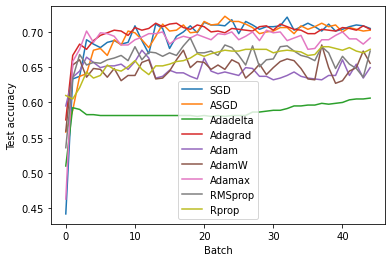

In [134]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(performance[:,0],label = 'SGD')
ax.plot(performance[:,1],label = 'ASGD')
ax.plot(performance[:,2],label = 'Adadelta')
ax.plot(performance[:,3],label = 'Adagrad')
ax.plot(performance[:,4],label = 'Adam')
ax.plot(performance[:,5],label = 'AdamW')
ax.plot(performance[:,6],label = 'Adamax')
ax.plot(performance[:,7],label = 'RMSprop')
ax.plot(performance[:,8],label = 'Rprop')
ax.legend()
#ax.set_xticks([0,2,4,6,8,10,12,14,16])
#ax.set_xticklabels(['0','100','200','300','400','500','600','700','800'])
ax.set_xlabel('Batch')
ax.set_ylabel('Test accuracy')

# Show

In [139]:
vocab = X.columns.tolist()

In [160]:
features = np.zeros(len(vocab))
for word in jieba.cut(input("Enter a review: ")):
    if word in vocab:
        features[vocab.index(word)] += 1
featuretorch = torch.from_numpy(features.astype(np.float32)).cuda()
if logreg(featuretorch).round() == 0:
    print('negative')
else:
    print('positive')

Enter a review: 我劝大家不要去，那地方就是坑人的地方，最垃圾的好伦哥，不信的可以去看看，看完保证和我评价一下
negative


In [159]:
for word in jieba.cut(input("Enter a sentence: ")):
    print(word)

Enter a sentence: 我在北京天安门
我
在
北京
天安门


In [154]:
print(" ".join(jieba.cut(input("Enter a sentence: "))))

Enter a sentence: 一个人的命运啊，当然要靠自我奋斗，但是也要考虑到历史的行程
一个 人 的 命运 啊 ， 当然 要 靠 自我 奋斗 ， 但是 也 要 考虑 到 历史 的 行程
